# MultiClass classifier one vs all

In [1]:

# Imports:

import numpy as np
from pprint import pprint
from tempfile import mkdtemp
from shutil import rmtree

# to make this notebook output stable across the runs:
np.random.seed(42)

# sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform

# to plot the pretty figures
%matplotlib inline
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc("axes", labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)
mpl.rc('figure', figsize = (8,6))


In [2]:
# Ignore all the warnings (convergence ...) by sklearn

def warn(*args, **kwargs):
  pass

import warnings
warnings.warn = warn

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version = 1, return_X_y = True)

In [4]:
# convert to numpy array

X = X_pd.to_numpy()
y = y_pd.to_numpy()

In [5]:
# Split the dataset into training and testing set.

x_train,x_test,y_train,y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# multiclass logit with sgd

In [6]:
estimator = SGDClassifier(loss = 'log',
                          penalty='l2',
                          max_iter=1,
                          warm_start=True,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [7]:
Loss=[]
iterations= 100
for i in range(iterations):
  pipe_sgd_ovr.fit(x_train,y_train)
  y_pred = pipe_sgd_ovr.predict_proba(x_train)
  Loss.append(log_loss(y_train,y_pred))

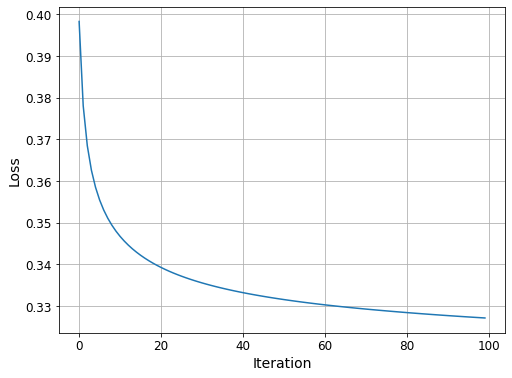

In [8]:
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

What actually happened behind the screen is that the library automatically created 10 binary
classifiers and trained them!. During the inference time, the input will be passed through all the
10 classifiers and the highest score among the ouputs will be considered as the predicted
class.To see it in action, let us execute the following lines of code

In [9]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [10]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

So it is a matrix of size 10 × 784. A row represents the weights of a single binary classifier.

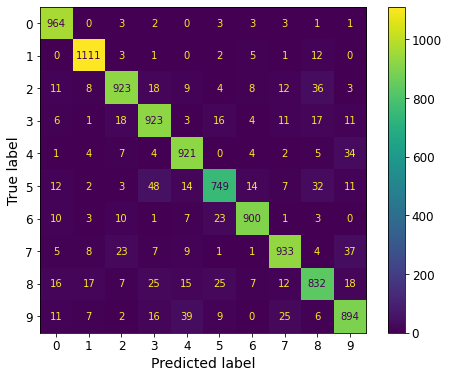

In [11]:
y_hat = pipe_sgd_ovr.predict(x_test); y_hat[:5]

cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat,values_format='.5g')

plt.show()

In [12]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



# Mulitclass classification using solvers

In [13]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(),
                               LogisticRegression(random_state=1729,
                                                  solver='lbfgs',
                                                  C=np.infty))
pipe_logit_ovr.fit(x_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

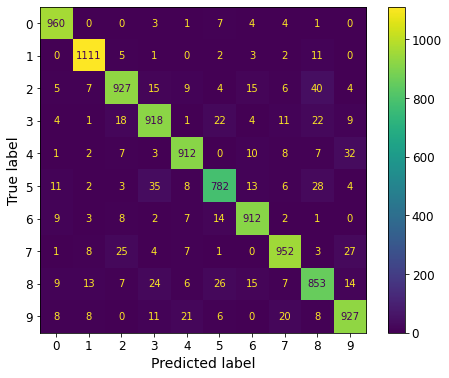

In [14]:
y_hat = pipe_logit_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat,values_format='.5g')

plt.show()

In [15]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



# Visualize the weight values

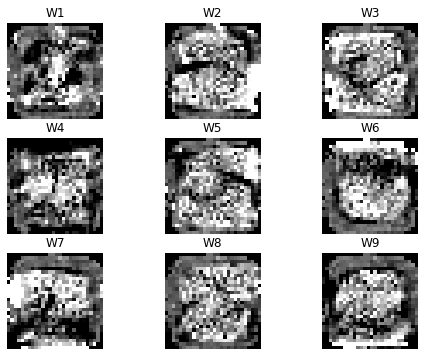

In [16]:
W = pipe_logit_ovr[1].coef_
# normalize
W = MinMaxScaler().fit_transform(W)
fig,ax = plt.subplots(3,3)
index = 1
for i in range(3):
  for j in range(3):
    ax[i][j].imshow(W[index,:].reshape(28,28),cmap='gray')
    ax[i][j].set_title('W{0}'.format(index))
    ax[i][j].set_axis_off()
    index += 1